Here I want to see how to use rompy to build RBs
by passing the entire training set in batches.

Mainly to reduce the memory footprint

In [1]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

In [2]:
import numpy as np

In [3]:
import scrinet.workflow.generators

In [4]:
import rompy as rp

In [5]:
M = 60

q_array = np.linspace(1, 2, 50)
(
    times,
    ts_amp,
    ts_phase,
    _,
    _,
    _,
    coords,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    q_array, M, n_cores=2, t_min=-1000
)

q_random = np.random.uniform(1, 2, 10)
(
    _,
    ts2_amp,
    ts2_phase,
    _,
    _,
    _,
    coords2,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    q_random, M, n_cores=2, t_min=-1000
)

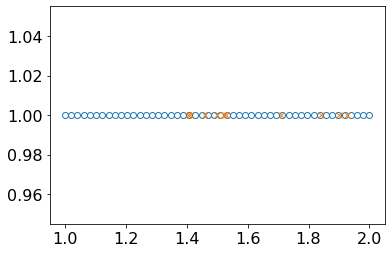

In [6]:
plt.figure()
plt.plot(q_array, np.ones_like(q_array), "o", markerfacecolor="None")
plt.plot(q_random, np.ones_like(q_random), "x")

In [8]:
times.shape

(5000,)

In [9]:
ts_amp.shape

(50, 5000)

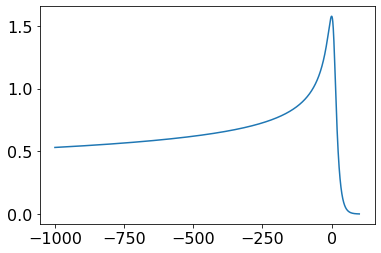

In [10]:
plt.figure()
plt.plot(times, ts_amp[0])

In [11]:
integration = rp.Integration([times[0], times[-1]], len(times), rule="trapezoidal")
x = integration.nodes

In [12]:
rb = rp.ReducedBasis(integration)

In [13]:
rb.make(ts_amp, 0, 1e-12, verbose=True, num=3)

('\nStep', '\t', 'Error')
(1, '\t', 543.0005818656455)
(2, '\t', 0.06269141716268223)
(3, '\t', 0.0008282199868290263)


In [15]:
rb.alpha.shape

(3, 50)

In [16]:
ts_amp.shape

(50, 5000)

In [17]:
rb._Nbasis

3

In [18]:
rb.make(ts2_amp, 0, 1e-12, verbose=True)

('\nStep', '\t', 'Error')
(1, '\t', 542.38237907684)
(2, '\t', 0.017870708768896293)
(3, '\t', 0.0005601413926115129)
(4, '\t', 1.2630766832444351e-06)
(5, '\t', 2.476225517966668e-07)
(6, '\t', 6.820732778578531e-08)
(7, '\t', 5.0699327402981e-08)
(8, '\t', 5.124775270815007e-09)
(9, '\t', 8.647020877106115e-10)
(10, '\t', 3.7766767491120845e-10)


In [19]:
rb.errors.shape

(10,)

In [20]:
rb._Nbasis

10

# class development 

In [21]:
# philosophy: use as much rompy as possible

# want to be able to seed the basis with an array of training data
# then supply batches of training data to update the basis

In [22]:
class MiniBatchGreedyReducedBasis(
    rp.greedy._ReducedBasis, rp.greedy._IteratedModifiedGramSchmidt
):
    """
    based upon Chad Galley's rompy package
    """

    def __init__(self, integration, loss="L2"):
        """
        integration {rompy.integrals.Integration}:
            instance of 'rompy.integrals.Integration'
        loss {str}:
            loss function to measure error between training
            data and its projection onto the reduced basis.
            only supports L2 norm right now
        """

        assert (
            type(integration) == rp.integrals.Integration
        ), "integration must be of type 'rompy.integrals.Integration'"

        self.integration = integration

        rp.greedy._ReducedBasis.__init__(self, integration)
        rp.greedy._IteratedModifiedGramSchmidt.__init__(self, integration)

        if loss == "L2":
            self.loss = self.proj_errors_from_alpha

    def build_seed_basis(self, ts, ts_coords, tol=0.5, max_iter=3):
        """
        use this to build an orthonormal set of basis functions
        from a given training set (ts)
        
        ts {np.ndarray}: shape=(N, M).
            N is the number of samples
            M is the number of time/freq points
        ts_coords {np.ndarray}: shape=(N,P)
            N is the number of samples
            P is the number of features/dimensionality
            
        sets the follow attributes
        self.greedy_points: same sa input ts_coords
        self.basis:
        self.norms:
        """
        
        self.greedy_points = ts_coords.copy()
        self.basis, self.basisnorms = self.make_basis(ts, norms=True, a=tol, max_iter=max_iter)
        
        self.indices = np.array(list(range(ts_coords.shape[0])))
        self.errors = self.basisnorms**2
        self.alpha = np.array([self.alpha_arr(b, ts) for b in self.basis])
        
    def iterate(self, step, errs, ts, ts_coords):
        next_index = np.argmax(errs)
        next_coords = ts_coords[next_index]
        # because we are dealing with disjoint mini-batches we cannot rely on their indicies to be unique.
        # so we use their coordinates
        if next_coords in self.greedy_points:
            print(f"next_coords: {next_coords}")
            print(">>> Warning(Point already selected): Exiting greedy algorithm.")
            return 1
        else:
            
            new_b, new_b_norm = self.add_basis(ts[next_index], self.basis[:step+1])
            
            
            self.errors = np.append(self.errors, errs[next_index])
            self.basis = np.row_stack((self.basis, new_b))
            self.basisnorms = np.append(self.basisnorms, new_b_norm)
            self.alpha = np.row_stack((self.alpha_arr(self.basis[step+1], ts)))
            
            
            
#             self.errors[step+1] = errs[next_index]
#             self.basis[step+1], self.basisnorms[step+1] = self.add_basis(ts[next_index], self.basis[:step+1])
#             self.alpha[step+1] = self.alpha_arr(self.basis[step+1], ts)

In [23]:
np.row_stack(([1,2],[3,4])).shape

(2, 2)

In [24]:
np.vstack(([1,2],[3,4]))

array([[1, 2],
       [3, 4]])

In [25]:
integration = rp.Integration([times[0], times[-1]], len(times), rule="trapezoidal")
x = integration.nodes

In [26]:
mb = MiniBatchGreedyReducedBasis(integration)

In [27]:
ts_seed = ts_amp[:3]
ts_seed_coords = q_array[:3]

ts = ts_amp[5:]
ts_coords = q_array[5:]

In [28]:
ts_seed.shape

(3, 5000)

In [29]:
ts.shape

(45, 5000)

In [30]:
# mb.build_seed_basis(ts_amp[[0,-1]], q_array[[0,-1]])
mb.build_seed_basis(ts_seed, ts_seed_coords)

In [31]:
mb.alpha.shape

(3, 3)

In [32]:
nn=1

In [33]:
norms = np.array([mb.inner.norm(tt) for tt in ts])

In [34]:
norms.shape

(45,)

In [35]:
rb.alpha.shape

(10, 10)

In [36]:
errs = mb.loss(mb.alpha)

In [37]:
errs

array([-536.77644763, -536.77773215, -536.79014503])

In [38]:
mb.iterate(step=0, errs=errs, ts=ts, ts_coords=ts_coords)

In [39]:
mb.alpha.shape

(45, 1)

In [40]:
# nn, flag = 0, 0
# while nn < ts.shape[0]:
#     mb.iter


# self.indicies keeps track of the number of greedy points
# batch_index keeps track of the current index in the current mini-batch
batch_index = 0
flag = 0
while batch_index < ts.shape[0]:
    


SyntaxError: unexpected EOF while parsing (<ipython-input-40-77ea0e847d16>, line 11)

In [41]:
mb.greedy_points

array([1.        , 1.02040816, 1.04081633])

In [42]:
mb.indices

array([0, 1, 2])

In [43]:
mb.errors

array([ 5.37776448e+02,  5.65148362e-09,  5.47259239e-07, -5.36776448e+02])

In [44]:
mb.alpha

array([[ 0.01534145],
       [-0.00448335],
       [ 0.02005263],
       [ 0.01477687],
       [ 0.01946033],
       [ 0.00057164],
       [ 0.02278227],
       [ 0.02245936],
       [ 0.00193045],
       [ 0.00239976],
       [ 0.01527562],
       [ 0.00505553],
       [ 0.02130072],
       [ 0.00975449],
       [ 0.0301672 ],
       [ 0.02609009],
       [ 0.01676149],
       [ 0.01377689],
       [ 0.03720558],
       [ 0.01730066],
       [ 0.02285345],
       [ 0.03813959],
       [ 0.03724008],
       [ 0.04183118],
       [ 0.03637959],
       [ 0.04448835],
       [ 0.04049785],
       [ 0.05098015],
       [ 0.02961409],
       [ 0.04690431],
       [ 0.05192817],
       [ 0.04124796],
       [ 0.0421698 ],
       [ 0.04075949],
       [ 0.0520921 ],
       [ 0.05115054],
       [ 0.0402036 ],
       [ 0.06612196],
       [ 0.04398513],
       [ 0.04901364],
       [ 0.05230843],
       [ 0.04892167],
       [ 0.06706998],
       [ 0.06162102],
       [ 0.07615291]])

In [45]:
mb.alpha.shape

(45, 1)

In [46]:
mb.basis.shape

(4, 5000)

IndexError: index 2 is out of bounds for axis 1 with size 1

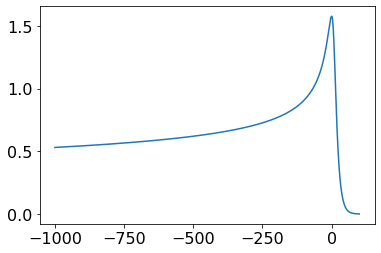

In [47]:
plt.plot(x, ts_seed[2])
plt.plot(x, np.dot(mb.alpha[:,2], mb.basis))

In [48]:
plt.plot(x, ts_seed[2] - np.dot(mb.alpha[:,2], mb.basis))

IndexError: index 2 is out of bounds for axis 1 with size 1

In [49]:
mb.basis.shape

(4, 5000)

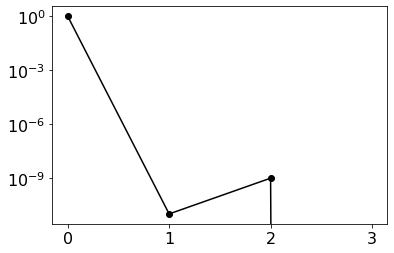

In [50]:
plt.figure()
plt.plot(mb.errors/mb.errors[0], 'k-o')
plt.yscale('log')

ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

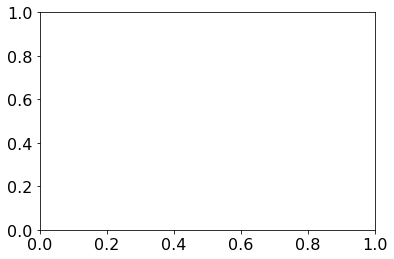

In [51]:
plt.figure()
plt.plot(ts_seed_coords, mb.errors, 'ko')
plt.yscale('log')

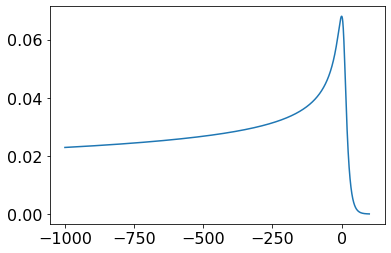

In [52]:
plt.figure()
plt.plot(x, mb.basis[0])